<a href="https://colab.research.google.com/github/Elshraby/GradProj4/blob/main/18_June_Gemini0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu
Successfully loaded and processed data. Found 451 unique turbine configurations.
Observed sequence lengths: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 38, 39, 40, 41, 43, 44, 45, 46, 48, 49, 53}
Dataset split: 360 training samples, 91 testing samples.
Static feature dimension: 38
Epoch [50/1000], Train Loss: 0.005333, Val Loss: 0.008589
Epoch [100/1000], Train Loss: 0.003149, Val Loss: 0.007823
Epoch [150/1000], Train Loss: 0.002400, Val Loss: 0.006657
Epoch [200/1000], Train Loss: 0.002510, Val Loss: 0.007410
Epoch [250/1000], Train Loss: 0.001192, Val Loss: 0.006740
Epoch [300/1000], Train Loss: 0.001242, Val Loss: 0.006708
Epoch [350/1000], Train Loss: 0.000986, Val Loss: 0.007145
Epoch [400/1000], Train Loss: 0.000816, Val Loss: 0.006831
Epoch [450/1000], Train Loss: 0.001975, Val Loss: 0.006601
Epoch [500/1000], Train Loss: 0.000702, Val Loss: 0.007190
Epoch [550/1000], Train Loss: 0

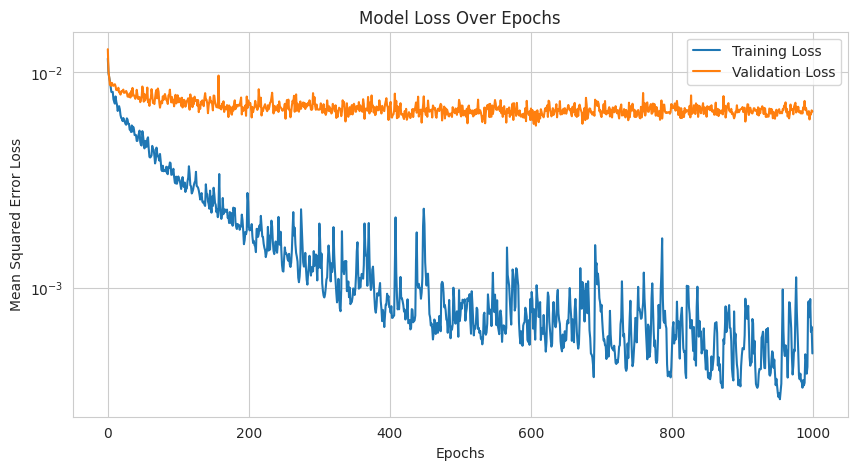


--- Visualizing Model Performance on Test Set ---


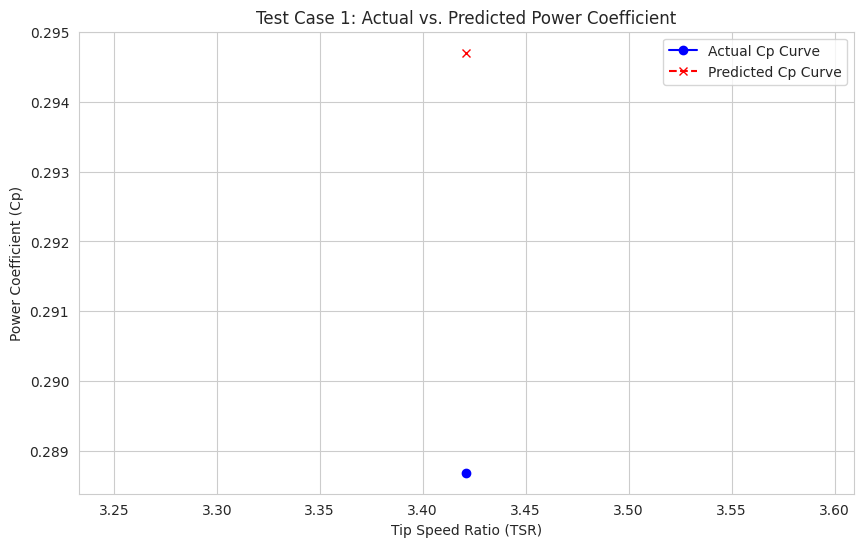

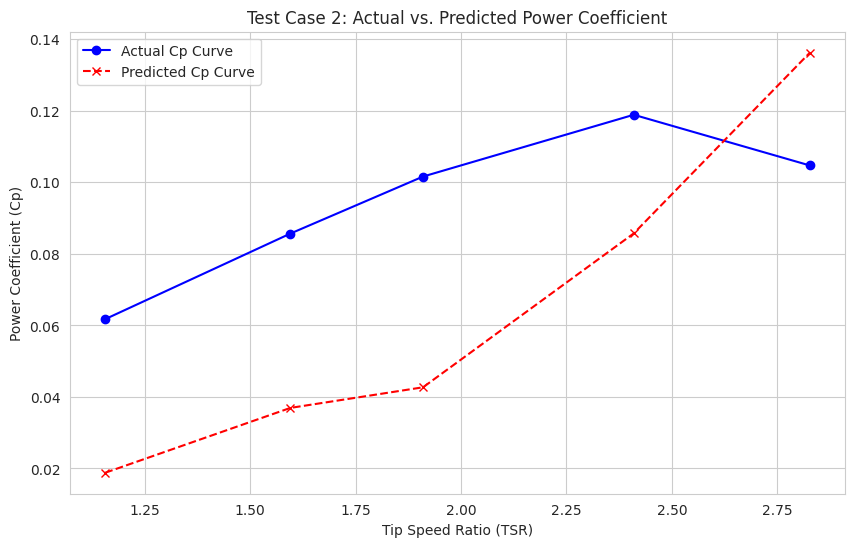

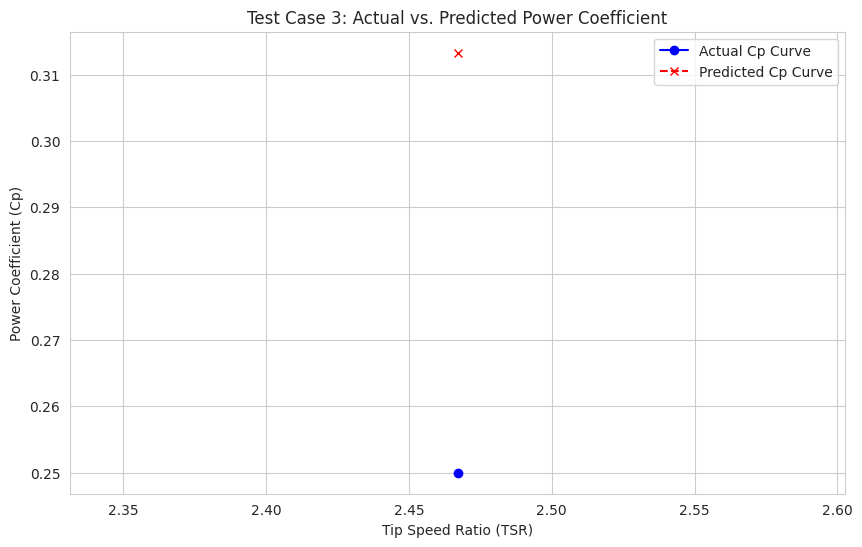

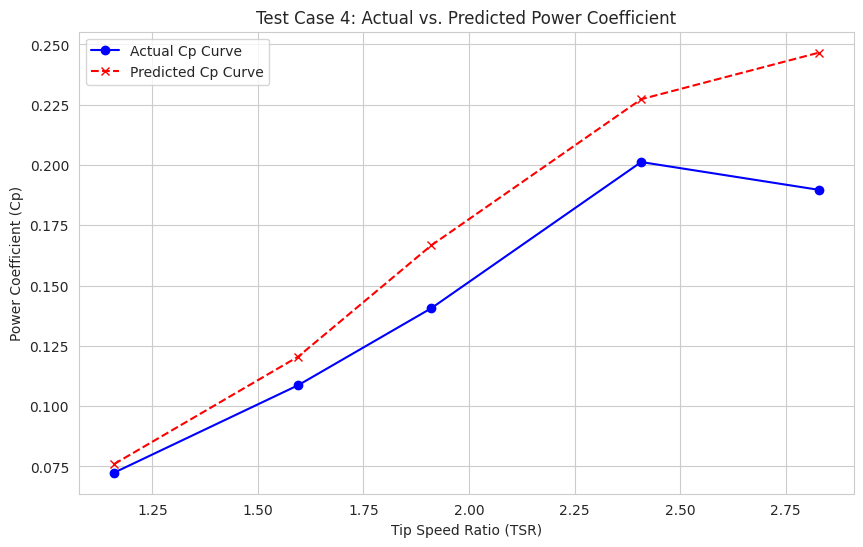

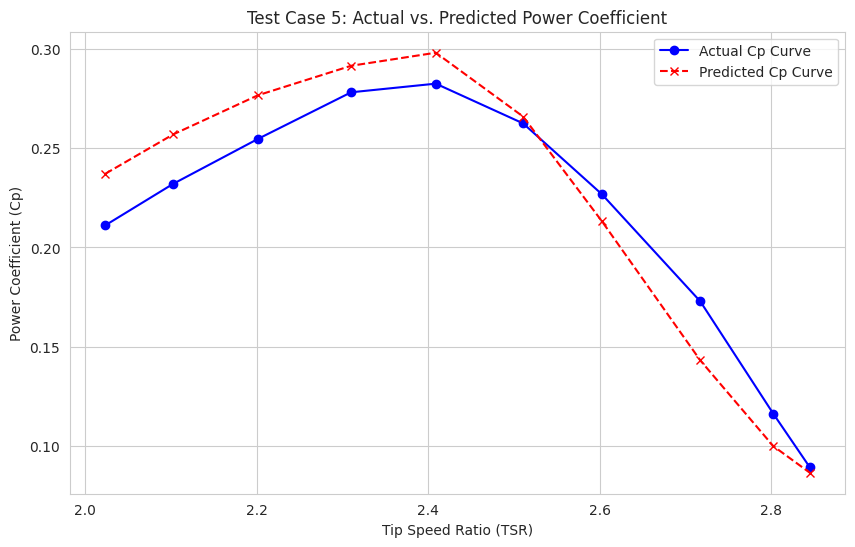

In [2]:
from IPython import get_ipython
from IPython.display import display
# %%
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

# Set style for plots
sns.set_style("whitegrid")

# --- 1. Data Loading and Preprocessing ---
def load_and_preprocess_data(file_path='Data.csv'):
    """
    Loads the dataset, identifies unique turbine configurations, and prepares
    the data for the PyTorch Dataset.

    Args:
        file_path (str): The path to the CSV data file.

    Returns:
        tuple: A tuple containing:
            - grouped_data (list): A list of tuples, where each tuple contains
              the static parameters and a DataFrame of varying TSR and Cp.
            - preprocessor (ColumnTransformer): The fitted preprocessing pipeline.
    """
    try:
        df = pd.read_csv(file_path)
        # Check if 'Power Coefficient' column exists, assume 'Cp' if not
        if 'Power Coefficient' not in df.columns and 'Cp' in df.columns:
             df = df.rename(columns={'Cp': 'Power Coefficient'})
             print("Renamed 'Cp' column to 'Power Coefficient'.")
        elif 'Power Coefficient' not in df.columns:
            print(f"Error: Neither 'Power Coefficient' nor 'Cp' column found in '{file_path}'.")
            print("Please ensure your data file contains a column for Power Coefficient.")
            return [], None # Return empty data to prevent further errors

    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        print("Please make sure your data file is uploaded to the Colab environment and the name matches.")
        # Create a dummy file for demonstration purposes if it doesn't exist
        print("Creating a dummy 'Data.csv' for demonstration.")
        dummy_data = {
            'Airfoil': ['NACA0012']*10 + ['NACA0015']*13 + ['S809']*8, # Varying lengths
            'Number of Blades': [3]*10 + [3]*13 + [4]*8,
            'Cord Length': [0.1]*10 + [0.12]*13 + [0.1]*8,
            'Height': [1.0]*23 + [1.2]*8,
            'Diameter': [0.8]*23 + [0.9]*8,
            'Pitch Angle': [2]*10 + [3]*13 + [2]*8,
            'Freestream Velocity': [8]*(10+13+8),
            'Tip Speed Ratio': list(np.linspace(1, 5.5, 10)) + list(np.linspace(1, 6, 13)) + list(np.linspace(1.5, 5, 8)), # Varying lengths
            'Power Coefficient': list(np.sin(np.linspace(1, 5.5, 10) - 2.5) * 0.4 + np.random.rand(10)*0.05) + \
                  list(np.sin(np.linspace(1, 6, 13) - 2.8) * 0.42 + np.random.rand(13)*0.05) + \
                  list(np.sin(np.linspace(1.5, 5, 8) - 2.5) * 0.45 + np.random.rand(8)*0.05)
        }
        df = pd.DataFrame(dummy_data)
        df.to_csv(file_path, index=False)
        print("Dummy 'Data.csv' created. Please replace it with your actual data.")


    # Define static parameters that identify a unique turbine configuration
    static_params = [
        'Airfoil', 'Number of Blades', 'Cord Length',
        'Height', 'Diameter', 'Pitch Angle', 'Freestream Velocity'
    ]
    # Define varying parameters and the output
    # Ensure 'Power Coefficient' is used consistently
    varying_params = ['Tip Speed Ratio', 'Power Coefficient']

    # Identify categorical and numerical features within the static parameters
    categorical_features = ['Airfoil']
    numerical_features = [col for col in static_params if col not in categorical_features]

    # Create a preprocessing pipeline for the static parameters
    # OneHotEncoder for the categorical 'Airfoil' column
    # MinMaxScaler for all numerical columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ],
        remainder='passthrough' # Keep other columns (if any), though we don't expect any
    )

    # Fit the preprocessor on the unique static configurations
    # Select only the static columns for fitting
    unique_configs = df[static_params].drop_duplicates()
    preprocessor.fit(unique_configs)

    # Group data by each unique configuration
    grouped = df.groupby(static_params)
    grouped_data = []
    for name, group in grouped:
        config_df = pd.DataFrame([name], columns=static_params)
        # Make sure to select the correct varying columns
        tsr_cp_df = group[varying_params].sort_values(by='Tip Speed Ratio').reset_index(drop=True)
        grouped_data.append((config_df, tsr_cp_df))

    print(f"Successfully loaded and processed data. Found {len(grouped_data)} unique turbine configurations.")
    # Print out lengths of sequences to debug potential issues
    sequence_lengths = [len(item[1]) for item in grouped_data]
    print(f"Observed sequence lengths: {set(sequence_lengths)}")


    return grouped_data, preprocessor

# --- 2. Custom PyTorch Dataset ---
class TurbineDataset(Dataset):
    """
    Custom PyTorch Dataset for the turbine data.
    Each item in the dataset represents a single turbine configuration and its
    corresponding TSR vs. Cp curve. Handles variable sequence lengths.
    """
    def __init__(self, grouped_data, preprocessor):
        """
        Args:
            grouped_data (list): The output from the load_and_preprocess_data function.
            preprocessor (ColumnTransformer): The fitted preprocessor for static features.
        """
        self.grouped_data = grouped_data
        self.preprocessor = preprocessor

    def __len__(self):
        return len(self.grouped_data)

    def __getitem__(self, idx):
        config_df, tsr_cp_df = self.grouped_data[idx]

        # Preprocess the static configuration parameters
        static_features = self.preprocessor.transform(config_df)
        # Ensure static_features is a numpy array before converting to tensor
        if hasattr(static_features, 'toarray'):
             static_features = static_features.toarray()
        static_tensor = torch.tensor(static_features.flatten(), dtype=torch.float32)

        # Get the sequence of Tip Speed Ratios (TSR) and Power Coefficients (Cp)
        tsr_sequence = torch.tensor(tsr_cp_df['Tip Speed Ratio'].values, dtype=torch.float32)
        cp_sequence = torch.tensor(tsr_cp_df['Power Coefficient'].values, dtype=torch.float32)

        # Return tensors and the original sequence length for padding handling
        return static_tensor, tsr_sequence, cp_sequence

# Custom collate function to handle variable sequence lengths by padding
def pad_collate_fn(batch):
    """
    Custom collate function to pad sequences within a batch.
    Pads TSR and Cp sequences to the maximum length in the batch.
    """
    static_tensors = [item[0] for item in batch]
    tsr_sequences = [item[1] for item in batch]
    cp_sequences = [item[2] for item in batch]

    # Stack static tensors (they should already be fixed size)
    static_batch = torch.stack(static_tensors, 0)

    # Find the maximum sequence length in the current batch
    max_len = max(len(seq) for seq in tsr_sequences)

    # Pad TSR and Cp sequences
    padded_tsr_batch = torch.zeros((len(batch), max_len), dtype=torch.float32)
    padded_cp_batch = torch.zeros((len(batch), max_len), dtype=torch.float32)
    # Create a mask to indicate which elements are not padding
    mask = torch.zeros((len(batch), max_len), dtype=torch.bool)

    for i, (tsr_seq, cp_seq) in enumerate(zip(tsr_sequences, cp_sequences)):
        seq_len = len(tsr_seq)
        padded_tsr_batch[i, :seq_len] = tsr_seq
        padded_cp_batch[i, :seq_len] = cp_seq
        mask[i, :seq_len] = True # Mark non-padded elements as True

    return static_batch, padded_tsr_batch, padded_cp_batch, mask


# --- 3. Model Architecture ---
class SurrogateModel(nn.Module):
    """
    A neural network model to predict Cp values for a given TSR sequence,
    conditioned on static turbine parameters.
    """
    def __init__(self, static_input_size, hidden_dim=256): # tsr_input_size is no longer needed here
        """
        Args:
            static_input_size (int): Dimension of the preprocessed static parameters.
            hidden_dim (int): The size of the hidden layers.
        """
        super(SurrogateModel, self).__init__()

        # Encoder for static parameters
        self.static_encoder = nn.Sequential(
            nn.Linear(static_input_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # Decoder to predict Cp from latent static representation and TSR
        # The input to the decoder will be the concatenation of the static latent
        # representation and the current TSR value.
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim + 1, hidden_dim), # hidden_dim (from static) + 1 (for TSR)
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1) # Predicts a single Cp value
        )


    def forward(self, static_params, tsr_sequence):
        """
        Forward pass of the model.
        Args:
            static_params (torch.Tensor): Tensor of static parameters (Batch_size, static_input_size).
            tsr_sequence (torch.Tensor): Tensor of TSR sequences (Batch_size, Sequence_length).
        Returns:
            torch.Tensor: Predicted Cp values (Batch_size, Sequence_length).
        """
        batch_size, seq_len = tsr_sequence.shape

        # Encode static parameters
        latent_representation = self.static_encoder(static_params) # Shape: (Batch_size, hidden_dim)

        # Repeat the latent representation for each TSR in the sequence
        # Shape: (Batch_size, Sequence_length, hidden_dim)
        latent_repeated = latent_representation.unsqueeze(1).repeat(1, seq_len, 1)

        # Reshape TSR sequence to (Batch_size, Sequence_length, 1)
        tsr_sequence_reshaped = tsr_sequence.unsqueeze(2)

        # Concatenate latent representation and TSR sequence
        # Shape: (Batch_size, Sequence_length, hidden_dim + 1)
        combined_input = torch.cat([latent_repeated, tsr_sequence_reshaped], dim=2)

        # Reshape for the decoder (flatten Batch and Sequence dims)
        # Shape: (Batch_size * Sequence_length, hidden_dim + 1)
        combined_input_flat = combined_input.view(batch_size * seq_len, -1)

        # Pass through the decoder
        # Shape: (Batch_size * Sequence_length, 1)
        predicted_cp_flat = self.decoder(combined_input_flat)

        # Reshape the output back to (Batch_size, Sequence_length)
        predicted_cp_curve = predicted_cp_flat.view(batch_size, seq_len)

        return predicted_cp_curve

# --- 4. Training and Validation ---
def train_model(model, train_loader, val_loader, num_epochs=500, learning_rate=1e-3, device='cpu'):
    """
    Function to train the surrogate model with padding and masking.

    Args:
        model (nn.Module): The PyTorch model to train.
        train_loader (DataLoader): DataLoader for the training set.
        val_loader (DataLoader): DataLoader for the validation set.
        num_epochs (int): Number of training epochs.
        learning_rate (float): Learning rate for the optimizer.
        device (str): The device to train on ('cpu' or 'cuda').

    Returns:
        tuple: A tuple containing:
            - best_model_state (dict): The state dict of the model with the lowest validation loss.
            - history (dict): A dictionary containing training and validation loss history.
    """
    # Use MSELoss, but we will apply the mask manually
    criterion = nn.MSELoss(reduction='none') # Use reduction='none' to get per-element loss
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.to(device)

    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        num_train_points = 0
        for static_params, tsr_curves, cp_curves, mask in train_loader:
            static_params, tsr_curves, cp_curves, mask = static_params.to(device), tsr_curves.to(device), cp_curves.to(device), mask.to(device)

            # Forward pass
            outputs = model(static_params, tsr_curves)

            # Calculate loss, apply mask
            loss = criterion(outputs, cp_curves)
            masked_loss = loss * mask.float() # Multiply loss by the mask
            # Sum the masked loss and divide by the number of non-padded elements
            batch_loss = masked_loss.sum() / mask.sum()

            # Backward and optimize
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            total_train_loss += batch_loss.item() * mask.sum().item() # Accumulate sum of losses
            num_train_points += mask.sum().item() # Accumulate number of non-padded points

        avg_train_loss = total_train_loss / num_train_points if num_train_points > 0 else 0
        history['train_loss'].append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        num_val_points = 0
        with torch.no_grad():
            for static_params, tsr_curves, cp_curves, mask in val_loader:
                static_params, tsr_curves, cp_curves, mask = static_params.to(device), tsr_curves.to(device), cp_curves.to(device), mask.to(device)
                outputs = model(static_params, tsr_curves)

                loss = criterion(outputs, cp_curves)
                masked_loss = loss * mask.float()
                batch_loss = masked_loss.sum() / mask.sum()

                total_val_loss += batch_loss.item() * mask.sum().item()
                num_val_points += mask.sum().item()

        avg_val_loss = total_val_loss / num_val_points if num_val_points > 0 else 0
        history['val_loss'].append(avg_val_loss)

        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            # print(f"New best model found at epoch {epoch+1} with validation loss: {avg_val_loss:.6f}")


    print("\nTraining Finished!")
    print(f"Best Validation Loss: {best_val_loss:.6f}")
    return best_model_state, history

# --- 5. Prediction and Visualization ---
def plot_training_history(history):
    """
    Plots the training and validation loss over epochs.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error Loss')
    plt.legend()
    plt.yscale('log')
    plt.show()

def visualize_predictions(model, loader, device='cpu', num_plots=5):
    """
    Visualizes model predictions against actual data for a few test cases.

    Args:
        model (nn.Module): The trained PyTorch model.
        loader (DataLoader): DataLoader for the test set.
        device (str): The device to run inference on.
        num_plots (int): The number of comparison plots to generate.
    """
    model.to(device)
    model.eval()

    print("\n--- Visualizing Model Performance on Test Set ---")

    # Get a few batches from the loader
    # The loader now yields 4 items: static_params, padded_tsr, padded_cp, mask
    batch_iterator = iter(loader)
    plotted_count = 0

    while plotted_count < num_plots:
        try:
            static_params_batch, tsr_curves_batch, cp_curves_batch, mask_batch = next(batch_iterator)
        except StopIteration:
            print(f"Visualized {plotted_count} plots. Ran out of data in the loader.")
            break # Stop if we run out of batches

        static_params_batch = static_params_batch.to(device)
        tsr_curves_batch = tsr_curves_batch.to(device)

        with torch.no_grad():
            predicted_cp_curves_padded = model(static_params_batch, tsr_curves_batch).cpu()

        # Iterate through samples in the current batch
        for i in range(static_params_batch.size(0)):
             if plotted_count >= num_plots:
                 break # Stop if we've generated enough plots

             # Get the original (unpadded) sequence length for this sample using the mask
             original_length = mask_batch[i].sum().item()

             # Extract the unpadded tensors
             tsr_curve = tsr_curves_batch[i, :original_length].cpu()
             actual_cp_curve = cp_curves_batch[i, :original_length].cpu()
             predicted_cp = predicted_cp_curves_padded[i, :original_length] # This output is already on CPU

             plt.figure(figsize=(10, 6))
             plt.plot(tsr_curve, actual_cp_curve, 'o-', label='Actual Cp Curve', color='blue')
             plt.plot(tsr_curve, predicted_cp, 'x--', label='Predicted Cp Curve', color='red')
             plt.title(f'Test Case {plotted_count+1}: Actual vs. Predicted Power Coefficient')
             plt.xlabel('Tip Speed Ratio (TSR)')
             plt.ylabel('Power Coefficient (Cp)')
             plt.legend()
             plt.show()

             plotted_count += 1


# --- 6. Main Execution Block ---
if __name__ == '__main__':
    # Configuration
    DATA_FILE = 'Data.csv'
    TRAIN_RATIO = 0.8
    BATCH_SIZE = 16
    NUM_EPOCHS = 1000
    LEARNING_RATE = 0.001
    HIDDEN_DIM = 256
    # NUM_LAYERS is less relevant in the new model structure as it's split between encoder/decoder
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {DEVICE}")

    # 1. Load and process data
    grouped_data, preprocessor = load_and_preprocess_data(DATA_FILE)

    if grouped_data:
        # 2. Create the full dataset
        full_dataset = TurbineDataset(grouped_data, preprocessor)

        # 3. Split dataset into training and validation
        train_size = int(TRAIN_RATIO * len(full_dataset))
        # Ensure test_size is at least 1 if dataset is not empty
        test_size = len(full_dataset) - train_size
        if len(full_dataset) > 0 and test_size == 0:
            train_size = len(full_dataset) - 1
            test_size = 1
            print(f"Adjusting split: {len(train_dataset)} training samples, {len(test_dataset)} testing samples (minimum 1 test sample).")


        # Check if train_size or test_size are zero after potential adjustment
        if train_size == 0 or test_size == 0:
             print("Error: Dataset size is too small to split into training and testing sets.")
        else:
            train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
            print(f"Dataset split: {len(train_dataset)} training samples, {len(test_dataset)} testing samples.")

            # 4. Create DataLoaders with custom collate function
            train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate_fn)
            test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate_fn)

            # 5. Initialize the model
            # Get input dimensions from the first data sample
            # We only need the static input dim now
            sample_static, _, _ = full_dataset[0]
            static_input_dim = sample_static.shape[0]
            # tsr_sequence_len is no longer needed for model init

            print(f"Static feature dimension: {static_input_dim}")


            surrogate_model = SurrogateModel(
                static_input_size=static_input_dim,
                hidden_dim=HIDDEN_DIM # NUM_LAYERS concept is now internal to encoder/decoder
            )

            # 6. Train the model
            best_model_state, history = train_model(
                model=surrogate_model,
                train_loader=train_loader,
                val_loader=test_loader, # Using test set for validation here for simplicity
                num_epochs=NUM_EPOCHS,
                learning_rate=LEARNING_RATE,
                device=DEVICE
            )

            # 7. Load the best performing model
            surrogate_model.load_state_dict(best_model_state)

            # 8. Visualize results
            plot_training_history(history)
            visualize_predictions(surrogate_model, test_loader, device=DEVICE, num_plots=5)
    else:
        print("No data processed. Exiting.")